In [1]:
import numpy as np
import mpcpy

In [2]:
time = np.arange(0.,24.01*3600.,3600.)
bcs = {'time': time,
       'T_amb': 5 + 2*np.sin(2*np.pi*time/24./3600.)+273.15,
       'Q_flow_sol': 500 + 500*np.sin(2*np.pi*time/24./3600.),
       'p_el': 0.2 + 0.05*np.sin(2*np.pi*time/24./3600.),
       'Q_flow_hp_max': 5000*np.ones_like(time),
       'T_in_min': 20*np.ones_like(time)+273.15,
       'T_em_max': 30*np.ones_like(time)+273.15}
boundaryconditions = mpcpy.Boundaryconditions(bcs,periodic=False)
print( boundaryconditions(1800) )
print( boundaryconditions(24.5*3600) )

{'p_el': 0.20647047612756303, 'Q_flow_hp_max': 5000.0, 'Q_flow_sol': 564.7047612756302, 'T_em_max': 303.15, 'time': 1800.0, 'T_amb': 278.4088190451025, 'T_in_min': 293.15}
{'p_el': 0.20000000000000004, 'Q_flow_hp_max': 5000.0, 'Q_flow_sol': 500.00000000000034, 'T_em_max': 303.15, 'time': 88200.0, 'T_amb': 278.15, 'T_in_min': 293.15}


In [3]:
import dympy

dymola = dympy.Dymola()
dymola.clear()
dymola.openModel('example.mo')
dymola.compile('example')

In [4]:
emulator = mpcpy.Emulator(dymola,['T_amb','Q_flow_sol','Q_flow_hp'])
inp = {'time': [0., 3600., 7200.], 'T_amb': [273.15, 274.15, 275.15], 'Q_flow_sol': [500., 400., 300.], 'Q_flow_hp': [4000., 4000., 4000.]}
emulator_parameters = {'C_em.C': 10e6, 'C_in.C': 5e6, 'UA_in_amb.G': 200, 'UA_em_in.G': 1600}
emulator.set_parameters(emulator_parameters)

emulator_initialconditions = {'C_em.T': 22+273.15, 'C_in.T': 21+273.15}
emulator.set_initial_conditions(emulator_initialconditions)

emulator.initialize()
emulator(inp)

print( emulator.res['time'] )
print( emulator.res['C_in.T'] )

[    0.  3600.  7200.]
[ 294.15008545  293.51867676  293.57620239]


In [5]:
class Stateestimation_perfect(mpcpy.Stateestimation):
    # redefine the stateestimation method
    def stateestimation(self,time):
        state = {}
        state['T_in'] = self.emulator.res['C_in.T'][-1]
        state['T_em'] = self.emulator.res['C_em.T'][-1]
        return state

stateestimation = Stateestimation_perfect(emulator)
print( stateestimation(0) )

{'T_in': 293.57620239257812, 'T_em': 295.7989501953125}


In [6]:
prediction = mpcpy.Prediction(boundaryconditions)
print( prediction([0.,1800.,3600.]) )

{'p_el': array([ 0.2       ,  0.20647048,  0.21294095]), 'Q_flow_hp_max': array([ 5000.,  5000.,  5000.]), 'Q_flow_sol': array([ 500.        ,  564.70476128,  629.40952255]), 'T_em_max': array([ 303.15,  303.15,  303.15]), 'time': array([    0.,  1800.,  3600.]), 'T_amb': array([ 278.15      ,  278.40881905,  278.66763809]), 'T_in_min': array([ 293.15,  293.15,  293.15])}


In [7]:
import cplex
class Linearprogram(mpcpy.Control):
    def formulation(self):
        # define temporary times, state estimations and prediction to use while defining the problem
        time = self.time(0)
        dt = time[1]-time[0]
        N = len(time)
        sta = self.stateestimation(time[0])
        pre = self.prediction(time)
        par = self.parameters

        ocp = cplex.Cplex()

        # shorthand for 1
        ones = np.ones(N)

        # add variables, don't wory about bounds yet as they will be set in the solution function
        ocp.variables.add(obj = 0*ones, lb = 0*ones, ub = 1e6*ones, names = ['Q_flow_hp[%s]'%(i) for i in range(N)])
        ocp.variables.add(obj = 0*ones, lb = 0*ones, ub = 1e6*ones, names = ['T_in[%s]'%(i) for i in range(N)])
        ocp.variables.add(obj = 0*ones, lb = 0*ones, ub = 1e6*ones, names = ['T_em[%s]'%(i) for i in range(N)])

        # add state constraints
        for i in range(N-1):
            # T_in
            # C_in/dt*(T_in[i+1]-T_in[i]) = UA_in_amb*(T_amb[i]-T_in[i]) + UA_em_in*(T_em[i]-T_in[i]) + Q_flow_sol[i]
            ocp.linear_constraints.add(
                    lin_expr = [[['T_in[%s]'%(i)                                   , 'T_in[%s]'%(i+1) , 'T_em[%s]'%(i)    ],
                                 [-par['C_in']/dt+par['UA_in_amb']+par['UA_em_in'] , par['C_in']/dt   , -par['UA_em_in']  ]]],
                    senses = 'E',
                    rhs = [par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i] ],
                    names = ['state_T_in[%s]'%(i)])


            # T_em
            # C_em/dt*(T_em[i+1]-T_em[i]) = UA_em_in*(T_in[i]-T_em[i]) + Q_flow_hp[i]
            ocp.linear_constraints.add(
                    lin_expr = [[['T_em[%s]'%(i)                  , 'T_em[%s]'%(i+1) , 'T_in[%s]'%(i)    , 'Q_flow_hp[%s]'%(i) ],
                                 [-par['C_em']/dt+par['UA_em_in'] ,  par['C_em']/dt  , -par['UA_em_in']  , -1                  ]]],
                    senses = 'E',
                    rhs = [0],
                    names = ['state_T_em[%s]'%(i)])

        # add initial values
        ocp.linear_constraints.add(lin_expr = [[['T_in[0]',   ],
                                                 [1]]],
                                   senses = 'E',
                                   rhs = [sta['T_in'].item()],
                                   names = ['T_in_ini'])

        ocp.linear_constraints.add(lin_expr = [[['T_em[0]',   ],
                                                 [1]]],
                                   senses = 'E',
                                   rhs = [sta['T_em'].item()],
                                   names = ['T_em_ini'])
            
            
        # disable output printing
        ocp.set_log_stream(None)
        #ocp.set_error_stream(None)
        ocp.set_warning_stream(None)
        ocp.set_results_stream(None)

        self.ocp = ocp
        
        def solution(sta,pre):
            # define the cost function
            ocp.objective.set_linear( [('Q_flow_hp[%s]'%(i),1/par['COP']*pre['p_el'][i]/1000*dt/3600) for i in range(N)] )

            # hard bounds
            ocp.variables.set_lower_bounds( [('T_in[%s]'%(i)     ,pre['T_in_min'][i]) for i in range(N)])
            ocp.variables.set_upper_bounds( [('Q_flow_hp[%s]'%(i),pre['Q_flow_hp_max'][i]) for i in range(N)]
                                           +[('T_em[%s]'%(i)     ,pre['T_em_max'][i]) for i in range(N)])
            
            
            # state constraints
            ocp.linear_constraints.set_rhs( [('state_T_in[%s]'%(i),par['UA_in_amb']*pre['T_amb'][i] + pre['Q_flow_sol'][i]) for i in range(N-1)]
                                           +[('state_T_em[%s]'%(i),0) for i in range(N-1)] )

            # initial conditions
            ocp.linear_constraints.set_rhs( [('T_in_ini',sta['T_in'].item())]
                                           +[('T_em_ini',sta['T_em'].item())] )
            
            # solve the optimal control problem
            ocp.solve()

            # add a properties with the ocp problem with the solution for inspection
            self.ocp = ocp

            # return the contol inputs
            sol = {}
            sol['time'] = pre['time']
            sol['Q_flow_hp'] = np.array( ocp.solution.get_values(['Q_flow_hp[%s]'%(i) for i in range(N)]) )

            return sol

        return solution


control_parameters = {'C_in': emulator_parameters['C_in.C'],
                      'C_em': emulator_parameters['C_em.C'],
                      'UA_in_amb': emulator_parameters['UA_in_amb.G'],
                      'UA_em_in': emulator_parameters['UA_em_in.G'],
                      'COP': 4}
control = Linearprogram(stateestimation,prediction,parameters=control_parameters,horizon=24*3600.,timestep=3600.,receding=3600.)

print( control.ocp.solution.get_status() )
print( control(0) )

0
{'Q_flow_hp': array([  937.33617849,     0.        ,  1694.25986254,  1417.19246022,
        1564.48272643,  1577.42585992,  1653.24089642,  1786.7611665 ,
        1968.8874844 ,  2187.20824254,  2426.84524203,  2671.46761738,
        2904.40475797,  3109.78238262,  3273.6043456 ,  3384.70645088,
        3435.51727357,  3422.57414008,  3346.75910358,  3213.2388335 ,
        3031.1125156 ,  2812.79175746,  2573.15475797,     0.        ,
           0.        ]), 'time': array([     0.,   3600.,   7200.,  10800.,  14400.,  18000.,  21600.,
        25200.,  28800.,  32400.,  36000.,  39600.,  43200.,  46800.,
        50400.,  54000.,  57600.,  61200.,  64800.,  68400.,  72000.,
        75600.,  79200.,  82800.,  86400.])}


In [8]:
mpc = mpcpy.MPC(emulator,control,boundaryconditions,emulationtime=1*24*3600.,resulttimestep=600)
res = mpc()
print(res['Q_flow_hp'])

Run MPC                                                                        |
--------------------------------------------------------------------------------  done
[  128.78747559   128.78747559   128.78747559   128.78747559   128.78747559
   128.78747559  1494.36812495  1142.31323242  1142.31323242  1142.31323242
  1142.31323242  1142.31323242  1142.31323242  1784.68145166  1480.41760254
  1480.41760254  1480.41760254  1480.41760254  1480.41760254  1480.41760254
  1609.711637    1513.21032715  1513.21032715  1513.21032715  1513.21032715
  1513.21032715  1513.21032715  1531.07468309  1501.22619629  1501.22619629
  1501.22619629  1501.22619629  1501.22619629  1501.22619629  1534.600978
  1525.85083008  1525.85083008  1525.85083008  1525.85083008  1525.85083008
  1525.85083008  1610.47793174  1608.80688477  1608.80688477  1608.80688477
  1608.80688477  1608.80688477  1608.80688477  1749.35766995  1750.71862793
  1750.71862793  1750.71862793  1750.71862793  1750.71862793  1750.7186279

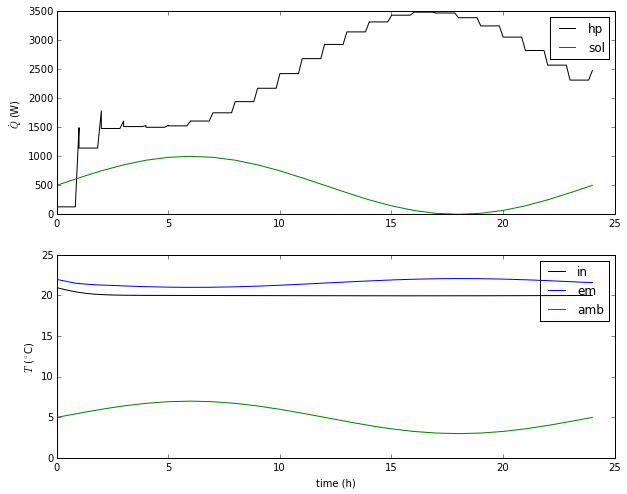

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
ax = plt.subplot(211)
ax.plot(res['time']/3600,res['Q_flow_hp'],'k',label='hp')
ax.plot(res['time']/3600,res['Q_flow_sol'],'g',label='sol')
ax.set_ylabel('$\dot{Q}$ (W)')
plt.legend()

ax = plt.subplot(212)
ax.plot(res['time']/3600,res['C_in.T']-273.17,'k',label='in')
ax.plot(res['time']/3600,res['C_em.T']-273.17,'b',label='em')
ax.plot(res['time']/3600,res['T_amb']-273.17,'g',label='amb')
ax.set_ylabel('$T$ ($^\circ$C)')
ax.set_xlabel('time (h)')
plt.legend()